In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys

if not os.getcwd().endswith('mob2crime'):
    os.chdir('..')
import folium

import src.mex_helper as mex_helper
import src.mex as mex
import src.mex.regions2010 as region
import src.mex.tower as tower
import src.tower_interpolation as tw_int
import src.utils.map_vis as mvis
import src.utils.gis as gis

from src.utils.map_vis import time_slider_choropleth, geojson_per_row
import src.ftrs.dilatation as ftr_dv

In [3]:
import pandas as pd
import src.features as ftr
import numpy as np

In [4]:
import geopandas as gp

In [ ]:
zms = region.mpa_all()
zms['Area'] = zms.area
# zms_area = zms.to_crs(mex.crs).geometry.apply(lambda x: x.area)
zms_sqrt_area = np.sqrt(zms.Area)

In [ ]:
zms_g2000 = region.mpa_grids(side=2000, per_mun=False)

# interpolate

In [5]:
call_direction = 'out+in'
aver = mex_helper.stat_tw_dow_aver_hr_uniq_user(call_direction)
avg_tw = pd.DataFrame(aver['wd']).T

loading cached tw average stats/stat_tw_dow_aver_hr_uniq_user-out+in.pickle


# dilitation

In [35]:
t2g2000_area = tw_int.to_mpa_grids(2000, by='area', per_mun=False)
t2g2000_area.set_index('grid', inplace=True)
avg_g2000_area = tw_int.interpolate_stats(avg_tw, t2g2000_area)

to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g2000_by_area.csv


In [21]:
gs_avg_idw2000 = tw_int.interpolate_idw(None, 2000, False)

interpolate_idw loading existing file data/mex_tw_intpl/interpolate_idw10_g2000.csv


In [36]:
dv_g2000_a = ftr_dv.dv_for_mpa_grids(avg_g2000_area, zms, zms_g2000)

In [38]:
%matplotlib inline

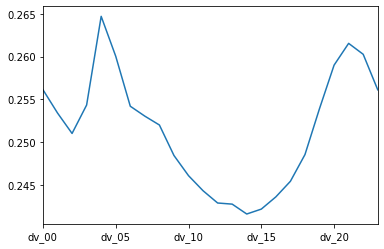

In [39]:
dv_g2000_a.loc[zms.index].iloc[0,:-1].plot()

# sampling moment of inertia

## Moment of Inertia in vector form

In [391]:
sub_target_hs = target_hs.iloc[27:30]

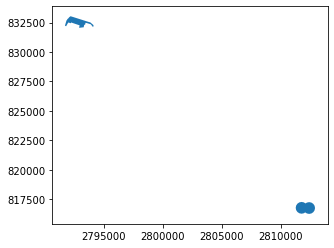

In [392]:
sub_target_hs.plot()

In [393]:
sub_target_hs_centroid = cascaded_union(sub_target_hs.geometry).centroid

In [394]:
sub_g = gis.gp_polys_to_grids(sub_target_hs, side=100, no_grid_by_area=True)

In [395]:
g_x = sub_g.centroid.apply(lambda x: x.coords[0][0])
g_y = sub_g.centroid.apply(lambda x: x.coords[0][1])


cx = (g_x*sub_g.area).sum() / sub_g.area.sum()
cy = (g_y*sub_g.area).sum() / sub_g.area.sum()

cx,cy,sub_target_hs_centroid.coords[:]

(2804542.3008907223,
 822926.4195838785,
 [(2803956.178589577, 823404.4977339791)])

In [360]:
sub_g_area = sub_g.area
d = cdist(sub_g.centroid.apply(lambda x: x.coords[0]).tolist(), [sub_target_hs_centroid.coords[0]])[:,0]

i_g = (sub_g_area**2)/6 + d** 2 * sub_g_area
i_g = i_g.sum()

i_0 = sub_g_area.sum()**2 / 2 / math.pi

i = i_0/i_g

i

0.023580085257251866

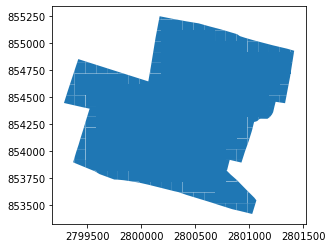

In [243]:
sub_g.plot()

In [253]:
sub_g_nc = gis.gp_polys_to_grids(sub_target_hs, side=100, no_grid_by_area=True, clip_by_poly=False, area_pcnt_thres=0.4)



sub_g_nc_area = sub_g_nc.area
d = cdist(sub_g_nc.centroid.apply(lambda x: x.coords[0]).tolist(), [sub_target_hs_centroid.coords[0]])[:,0]

i_g = (sub_g_nc_area**2)/6 + d** 2 * sub_g_nc_area
i_g = i_g.sum()

i_0 = sub_g_nc_area.sum()**2 / 2 / math.pi

i = i_0/i_g

i

0.8737884408674034

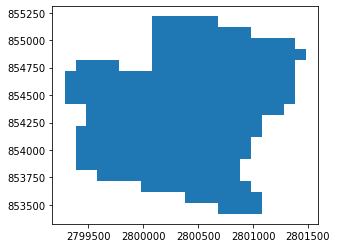

In [215]:

sub_g_nc.plot()

## average distance to a circle is 2R/3

https://math.stackexchange.com/questions/3019165/average-distance-from-center-of-circle

In [77]:
import math
import random
def rand_point_in_circle(radius):
    r = radius * math.sqrt(random.random())
    theta = random.random() * 2 * math.pi
    x = r * math.cos(theta)
    y = r * math.sin(theta)
    return x, y

In [78]:

avg_dist = []
for rad in range(1, 20):
    dists = []
    for _ in range(100000):
        x1,y1=rand_point_in_circle(rad)
        dist = math.sqrt(x1**2+y1**2)
        dists.append(dist)
    avg_dist.append({'rad': rad, 'dist':sum(dists)/len(dists)})
avg_dist_pd = pd.DataFrame(avg_dist)

In [85]:
avg_dist_pd['ratio'] = avg_dist_pd.dist/avg_dist_pd.dist[0]
avg_dist_pd['rad**2'] = avg_dist_pd.rad**2
avg_dist_pd['ration/rad**2']=avg_dist_pd.ratio/avg_dist_pd['rad**2']
avg_dist_pd['ration/rad']=avg_dist_pd.ratio/avg_dist_pd['rad']
avg_dist_pd['dist/(2R/3)'] = avg_dist_pd.dist / (2*avg_dist_pd.rad/3)

In [86]:
avg_dist_pd

,rad,dist,ratio,rad**2,ration/rad**2,ration/rad,dist/(2R/3)
0,1,0.665913,1.000000,1,1.000000,1.000000,0.998870
1,2,1.335742,2.005880,4,0.501470,1.002940,1.001807
2,3,1.998839,3.001651,9,0.333517,1.000550,0.999420
3,4,2.668318,4.007005,16,0.250438,1.001751,1.000619
4,5,3.330542,5.001466,25,0.200059,1.000293,0.999163
5,6,4.003661,6.012287,36,0.167008,1.002048,1.000915
6,7,4.668991,7.011411,49,0.143090,1.001630,1.000498
7,8,5.331069,8.005652,64,0.125088,1.000706,0.999575
8,9,5.999499,9.009431,81,0.111228,1.001048,0.999916
9,10,6.663433,10.006459,100,0.100065,1.000646,0.999515


## average distance-square of a circle is ~ radius**2

### random sampling

In [7]:
import math
import random

In [29]:
def rand_point_in_circle(radius):
    r = radius * math.sqrt(random.random())
    theta = random.random() * 2 * math.pi
    x = r * math.cos(theta)
    y = r * math.sin(theta)
    return x, y

In [45]:

avg_dist = []
for rad in range(1, 20):
    dist_squares = []
    dists = []
    for _ in range(100000):
        x1,y1=rand_point_in_circle(rad)
        x2,y2=rand_point_in_circle(rad)

        dist = math.sqrt((x1-x2)**2 + (y1-y2)**2)
        dist_square=(x1-x2)**2 + (y1-y2)**2
        dists.append(dist)
        dist_squares.append(dist_square)

    avg_dist.append({'rad': rad, 'dist':sum(dists)/len(dists), 'dist_2':sum(dist_squares)/len(dist_squares)})

In [54]:
avg_dist_pd = pd.DataFrame(avg_dist)

In [57]:
avg_dist_pd['ratio'] = avg_dist_pd.dist_2/avg_dist_pd.dist_2[0]
avg_dist_pd['rad**2'] = avg_dist_pd.rad**2
avg_dist_pd['ration/rad**2']=avg_dist_pd.ratio/avg_dist_pd['rad**2']

In [58]:
# http://mathworld.wolfram.com/DiskLinePicking.html: average distance is 128/45/pi ~= 0.905
avg_dist_pd

,rad,dist,dist_2,ratio,rad**2,ration/rad**2
0,1,0.905992,1.002213,1.000000,1,1.000000
1,2,1.813226,4.006565,3.997720,4,0.999430
2,3,2.715005,8.989880,8.970032,9,0.996670
3,4,3.625679,16.026201,15.990818,16,0.999426
4,5,4.522896,24.957895,24.902792,25,0.996112
5,6,5.443927,36.139776,36.059985,36,1.001666
6,7,6.333444,48.864130,48.756246,49,0.995025
7,8,7.230904,63.721727,63.581040,64,0.993454
8,9,8.148899,80.977775,80.798989,81,0.997518
9,10,9.059164,100.137692,99.916605,100,0.999166


### uniform grids

In [5]:
from shapely.geometry import Point

In [6]:
radius = 1
circle = Point(0,0).buffer(radius)


In [16]:
grids, _, _ = gis.poly2grids(circle, 0.01)
n = len(grids)
n

31748

In [17]:
grids = gp.GeoDataFrame(grids, columns=['geometry'])

grids.crs = mex.crs

In [18]:
dist = gis.polys_centroid_pairwise_dist(grids, mex.crs)

In [19]:
dist.sum()/n/(n-1)

0.9101091770815215

In [20]:
(dist**2).sum()/n/(n-1)

1.0103499818000863

In [42]:
len(dist)

31748

In [44]:
len(g)

32974

# Test NMI and NMMI

## test case for NMI and NMMI

In [307]:
from shapely.geometry import box


In [343]:
data = []
for i in range(10):
    for j in range(10):
        data.append({'i': i, 'j':j, 'geometry':box(i, j, i+1, j+1)})
data = gp.GeoDataFrame(data)

In [344]:
data

,i,j,geometry
0,0,0,"POLYGON ((1.00000 0.00000, 1.00000 1.00000, 0...."
1,0,1,"POLYGON ((1.00000 1.00000, 1.00000 2.00000, 0...."
2,0,2,"POLYGON ((1.00000 2.00000, 1.00000 3.00000, 0...."
3,0,3,"POLYGON ((1.00000 3.00000, 1.00000 4.00000, 0...."
4,0,4,"POLYGON ((1.00000 4.00000, 1.00000 5.00000, 0...."
...,...,...,...
95,9,5,"POLYGON ((10.00000 5.00000, 10.00000 6.00000, ..."
96,9,6,"POLYGON ((10.00000 6.00000, 10.00000 7.00000, ..."
97,9,7,"POLYGON ((10.00000 7.00000, 10.00000 8.00000, ..."
98,9,8,"POLYGON ((10.00000 8.00000, 10.00000 9.00000, ..."


In [345]:
data['Area'] = data.area

In [346]:
rx = data.centroid.apply(lambda x: x.coords[0][0])
ry = data.centroid.apply(lambda x: x.coords[0][1])
cx = (rx * data.area).sum() / data.area.sum()
cy = (ry * data.area).sum() / data.area.sum()
data_centroid = (cx, cy)
data_centroid

(5.0, 5.0)

In [347]:
data_centroid_centroids = data.centroid.apply(lambda x: x.coords[0]).tolist()

data_d2centroid = cdist(data_centroid_centroids, [data_centroid])[:,0]

In [348]:
%matplotlib inline

In [349]:

data['type1'] = data.apply(lambda row: row.j== 4 or row.j==5, axis=1)

data['type2'] = data.apply(lambda row: row.j>=4 and row.j<6 and row.i>=4 and row.i<6, axis=1)
def dtype3(row,shift=0):
    i= row.i
    j= row.j
    return (j >=3+shift and j< 7+shift and (i==2+shift or i==7+shift)) or (j>=2+shift and j<8+shift and i>=3+shift and i<7+shift)
data['type3'] = data.apply(dtype3, axis=1)


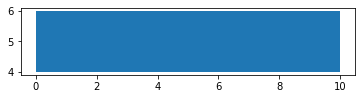

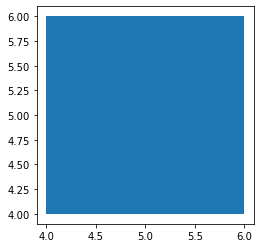

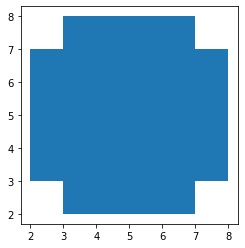

In [350]:
data[data['type1']].plot()
data[data['type2']].plot()


data[data.type3].plot()

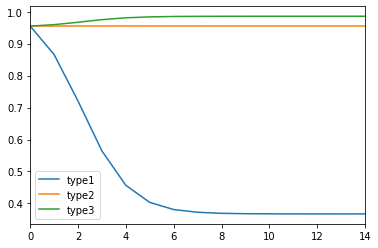

In [316]:
res = {}
for dentype in ['type1', 'type2', 'type3']:
    nmmis = []

    for i in range(15):
        density_coef = np.e**i
        data['Density'] = data[dentype].apply(lambda x: density_coef if x else 1)
        data['Mass'] = data.area* data.Density
        cx = (rx * data.Mass).sum() / data.Mass.sum()
        cy = (ry * data.Mass).sum() / data.Mass.sum()
        data_mass_centroid = (cx, cy)
        assert np.isclose(data_mass_centroid, data_centroid).mean()==1
        nmmis.append(ftrs_hs.mass_moment_inertia(data, data_d2centroid))
    res[dentype] = nmmis

pd.DataFrame(res).plot()


In [196]:
pd.DataFrame(res)

,type1,type2,type3
0,0.954930,0.95493,0.954930
1,0.865837,0.95493,0.959416
2,0.720337,0.95493,0.966879
3,0.564155,0.95493,0.975087
4,0.456668,0.95493,0.980857
5,0.403264,0.95493,0.983762
6,0.380994,0.95493,0.984981
7,0.372393,0.95493,0.985453
8,0.369171,0.95493,0.985630
9,0.367977,0.95493,0.985696


## test case 2

In [352]:
data = []
for i in range(30):
    for j in range(15):
        data.append({'i': i, 'j':j, 'geometry':box(i, j, i+1, j+1)})
data = gp.GeoDataFrame(data)

In [353]:
data['Area'] = data.area

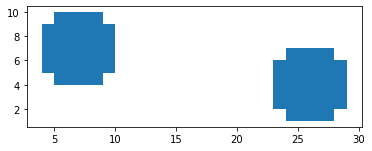

In [355]:
def city(row,shifti=0,shiftj=0):
    i= row.i
    j= row.j
    return (j >=3+shiftj and j< 7+shiftj and (i==2+shifti or i==7+shifti)) or (j>=2+shiftj and j<8+shiftj and i>=3+shifti and i<7+shifti)
data['cityA'] = data.apply(lambda x: city(x,2,2), axis=1)
data['cityB'] = data.apply(lambda x: city(x,21,-1), axis=1)

data[data.cityA|data.cityB].plot()

In [357]:
data['Da']=data.cityA*np.e**20

In [366]:
data_centroid_centroids = data.centroid.apply(lambda x: x.coords[0]).tolist()

rx = data.centroid.apply(lambda x: x.coords[0][0])
ry = data.centroid.apply(lambda x: x.coords[0][1])
cx = (rx * data.area).sum() / data.area.sum()
cy = (ry * data.area).sum() / data.area.sum()
data_centroid = (cx, cy)

data_d2centroid = cdist(data_centroid_centroids, [data_centroid])[:,0]

In [370]:
nmmis = []

for i in range(30):
    data['Db'] = data.cityB * np.e**i
    data['Density'] = data.Da + data.Db
    data['Mass'] = data.area * data.Density
    cx = (rx * data.Mass).sum() / data.Mass.sum()
    cy = (ry * data.Mass).sum() / data.Mass.sum()
    data_mass_centroid = (cx, cy)
    data_d2mass_centroid = cdist(data_centroid_centroids,[data_mass_centroid])[:, 0]
    nmmis.append(ftrs_hs.mass_moment_inertia(data, data_d2mass_centroid))
nmmis = pd.DataFrame(nmmis)

In [368]:
ftrs_hs.moment_inertia(data.Area,data_d2centroid)

0.7639437268410973

In [374]:
nmmis

,0
0,0.985734
1,0.985733
2,0.985733
3,0.985731
4,0.985726
5,0.985713
6,0.985677
7,0.985579
8,0.985312
9,0.984589


In [373]:
nmmis.min(), nmmis.values.argmin()

(0    0.100527
 dtype: float64, 21)

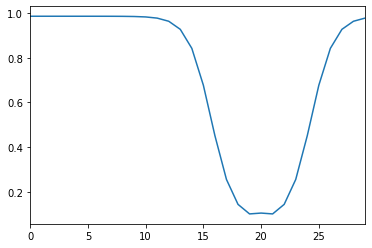

In [364]:
nmmis.plot()

# hotspot

In [6]:
import src.ftrs.hotspot as ftrs_hs
from shapely.ops import cascaded_union
from shapely.geometry import Point
from scipy.spatial.distance import cdist


## AGEB

In [7]:

mg_mappings = region.ageb_ids_per_mpa()
zms = region.mpa_all()
zms['Area'] = zms.area

print('loading agebs')
zms_mun_ids = mg_mappings.mun_id.unique()
zms_loc_ids = mg_mappings.loc_id.unique()
zms_agebs = region.agebs(zms_mun_ids, zms_loc_ids)
mg_mappings = region.ageb_ids_per_mpa()

loading agebs


In [8]:
by = 'area'
t2a = tw_int.to_mpa_agebs(by)
t2a.set_index('ageb', inplace=True)
avg_a = tw_int.interpolate_stats(avg_tw, t2a)

to_map_agebs loading existing file data/mex_tw_intpl/tower_to_mpa_agebs_by_area.csv


In [621]:

for sun, zm_mapping in mg_mappings.groupby('CVE_SUN'):
    if sun!=1: continue
    print(sun, end=' ')
    zm = zms.loc[sun]
    zm_a = zms_agebs.loc[zm_mapping.ageb_id].copy()
    zm_avg_a = avg_a.loc[zm_a.index].copy()
    hs_ageb = ftrs_hs.HotSpot(zm_avg_a, zm_a, zm, 'loubar', verbose=1)
#     hs.calc_stats()
    break
hs_ageb._get_hs()

1 masking out non hot spot, defined by loubar


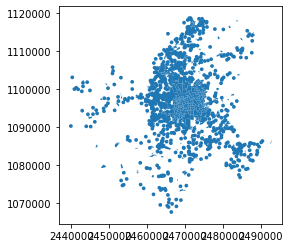

In [622]:
zm_a.plot()

## grids

In [601]:
per_mun=True

In [578]:
per_mun=True
zms_grids = region.mpa_grids(500, per_mun, False)

loading existing file data/mexico/geography-socioeconomics/2010MetropolitanAreas/grids_500_perMun_uNr.geojson.gz


In [579]:
t2g = tw_int.to_mpa_grids(500, by='area',per_mun,urb_only=False,grids=zms_grids)
t2g.set_index('grid', inplace=True)
avg_g = tw_int.interpolate_stats(avg_tw, t2g)

to_map_grids loading existing file data/mex_tw_intpl/tower_to_mpa_g500_perMun_uNr_area.csv


In [619]:

for sun in sorted(zms.index):
    if sun!=1: continue
    print(sun, end=' ')
    zm = zms.loc[sun]
    zm_g = zms_grids[zms_grids.CVE_SUN == sun].copy()
    zm_avg_g = avg_g.reindex(zm_g.index, fill_value=0).copy()
    hs_grid = ftrs_hs.HotSpot(zm_avg_g, zm_g, zm, 'loubar', verbose=1)
        # TODO: hs_stats can merge, they differ in how to obtain mun_level hotspot
#     if per_mun:
#         hs_avg = []
#         for _, mun_g in zm_g.groupby('mun_id'):
#             mun_avg_g = avg_g.reindex(mun_g.index, fill_value=0).copy()
#             # print(sun, mun_g.mun_id.iloc[0],'mun g not in avg', set(mun_g.index) - set(avg_g.index))
#             # print('mun_avg_g isnull', mun_avg_g.isnull().sum(), mun_avg_g.shape)
#             if len(mun_g) < 10:
#                 continue
#             mun_hot = ftrs_hs.keep_hotspot(mun_avg_g, 'loubar')
#             hs_avg.append(mun_hot)
#         hs_avg = pd.concat(hs_avg).reindex(zm_g.index, fill_value=0)

#     hs_grid.calc_stats(hs_avg)
#     break


1 

In [620]:
hs_grid._get_hs()

masking out non hot spot, defined by loubar


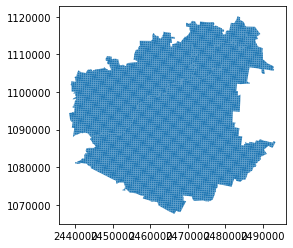

In [613]:
zm_g.plot()

## vor

In [606]:
per_mun=True
zms_vors = region.mpa_vors(per_mun, False)

[autoreload of src.ftrs.hotspot failed: Traceback (most recent call last):
  File "/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 312, in update_instances
    update_instances(old, new, obj.__dict__, visited)
  File "/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/si

loading existing mexico tower voronoi file: data/mex_tw_intpl/voronoi.geojson
computing the intersection between p1 tower and p2 mun_id
len(p1)=5731 > 10 * len(p2)=367, swap them
computing area of the intersections
computing the weight


In [609]:
t2v = tw_int.to_mpa_vors('area',per_mun,urb_only=False,zms_vors=zms_vors)
t2v.set_index('vor', inplace=True)
avg_vor = tw_int.interpolate_stats(avg_tw, t2v)

computing to_map_vors area True False


In [617]:

for sun in sorted(zms.index):
    if sun!=1: continue
    print(sun, end=' ')
    zm = zms.loc[sun]
    zm_v = zms_vors[zms_vors.CVE_SUN == sun].copy()
    zm_avg_vor = avg_vor.reindex(zm_v.index, fill_value=0).copy()
    hs_vor = ftrs_hs.HotSpot(zm_avg_vor, zm_v, zm, 'loubar', verbose=1)
        # TODO: hs_stats can merge, they differ in how to obtain mun_level hotspot
#     if per_mun:
#         hs_avg = []
#         for _, mun_g in zm_v.groupby('mun_id'):
#             mun_avg_vor = avg_vor.reindex(mun_g.index, fill_value=0).copy()
#             # print(sun, mun_g.mun_id.iloc[0],'mun g not in avg', set(mun_g.index) - set(avg_vor.index))
#             # print('mun_avg_vor isnull', mun_avg_vor.isnull().sum(), mun_avg_vor.shape)
#             if len(mun_g) < 10:
#                 continue
#             mun_hot = ftrs_hs.keep_hotspot(mun_avg_vor, 'loubar')
#             hs_avg.append(mun_hot)
#         hs_avg = pd.concat(hs_avg).reindex(zm_v.index, fill_value=0)

#     hs_vor.calc_stats(hs_avg)
#     break


1 

In [618]:
hs_vor._get_hs()

masking out non hot spot, defined by loubar


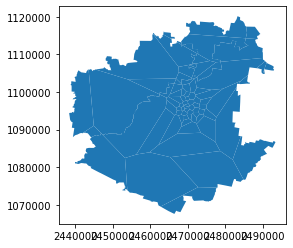

In [616]:
zm_v.plot()

## hotspots cal

In [582]:
def get_target_hs(hs):
    hs_count = hs.hs_avg['23']
    hs_count = hs_count[hs_count != 0]
    target_hs = hs.geoms.loc[hs_count.index]
    print(target_hs.shape)
    return target_hs, hs_count

In [583]:
import matplotlib.pyplot as plt

(57, 10)
(148, 3)
(21, 9)


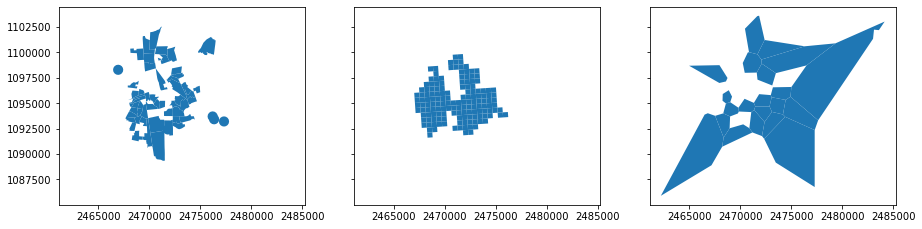

In [623]:
fig, (ax1, ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,6), sharex=True, sharey=True)
get_target_hs(hs_ageb)[0].plot(ax=ax1)

get_target_hs(hs_grid)[0].plot(ax=ax2)
get_target_hs(hs_vor)[0].plot(ax=ax3)

In [584]:
# target_hs=get_target_hs(hs_grid)
target_hs, hs_count=get_target_hs(hs_ageb)

hs_density = hs_count / target_hs.area
hs_density.name = 'Density'

(57, 10)


In [585]:
hs_pair_d_avg = ftrs_hs.avg_dist(target_hs)  # distance among hotspots
comp_coef = ftrs_hs.compacity_coefficient(hs_pair_d_avg, hs.sqrt_area)


In [586]:
raster_rper = gis.gp_polys_to_raster_centroids(target_hs, side=hs.raster_resolution, pname=target_hs.index.name)
raster_rper = raster_rper.merge(hs_density.reset_index())
raster_rper['Area'] = hs.raster_resolution ** 2
raster_rper['Mass'] = raster_rper.Area * raster_rper.Density

rx = raster_rper.centroid.apply(lambda x: x.coords[0][0])
ry = raster_rper.centroid.apply(lambda x: x.coords[0][1])
cx = (rx * raster_rper.Area).sum() / raster_rper.Area.sum()
cy = (ry * raster_rper.Area).sum() / raster_rper.Area.sum()
raster_centroid = (cx, cy)
cx = (rx * raster_rper.Mass).sum() / raster_rper.Mass.sum()
cy = (ry * raster_rper.Mass).sum() / raster_rper.Mass.sum()
raster_mass_centroid = (cx, cy)

raster_rper_centroids = raster_rper.centroid.apply(lambda x: x.coords[0]).tolist()

raster_centroid, raster_mass_centroid

((2471457.784831367, 1095567.4336247277),
 (2471309.063709641, 1095294.7766128208))

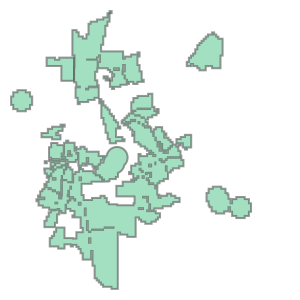

In [571]:
cascaded_union(raster_rper.centroid.apply(lambda x: gis.centroid2grid(x.coords[0],hs.raster_resolution)).tolist()+
               [Point(raster_centroid).buffer(500), 
                Point(raster_mass_centroid).buffer(500)])

In [572]:
# rasterize pairwise and to centroid distance
pairwise_dist_square_avg = ftrs_hs.avg_dist_square(raster_rper)
d2centroid = cdist(raster_rper_centroids, [raster_centroid])[:,0]
d2centroid_avg = d2centroid.mean()
d2mass_centroid = cdist(raster_rper_centroids, [raster_mass_centroid])[:,0]
d2mass_centroid_avg = d2mass_centroid.mean()

In [573]:
pairwise_dist_square_avg

30663938.73862413

In [574]:
d2centroid_avg

3600.62887865317

In [575]:
d2mass_centroid

array([3064.40345816, 2966.7441234 , 2946.4999838 , ..., 6481.20798119,
       6573.24251992, 6665.50654908])

In [576]:

ref_circle_radius = np.sqrt(raster_rper.Area.sum() / np.pi)
coh = ftrs_hs.cohesion(ref_circle_radius, pairwise_dist_square_avg)
prox = ftrs_hs.proximity(ref_circle_radius, d2centroid_avg)
nmi = ftrs_hs.moment_inertia(raster_rper.Area, d2centroid)
nmmi = ftrs_hs.mass_moment_inertia(raster_rper, d2centroid)

In [556]:
coh, prox, nmi,nmmi

(0.7342012537050522,
 0.8592783143605415,
 0.7342471235606016,
 0.6531041491317425)

## visulization

In [66]:
import src.utils.map_vis as mvis

In [67]:
raster_rper['color'] = raster_rper.Mass/raster_rper.Mass.max()


print('building map')
m = folium.Map(location=[mex.clat, mex.clon], zoom_start=5)
mvis.geojson_per_row_color_col(
    raster_rper.to_crs(epsg=4326), name='raster_rper', 
    tip_cols=['ageb_id', 'Mass', 'color'], color_col='color', some_map=m)


folium.LayerControl().add_to(m)
m.save('raster_rper.html')